# Decision trees with Bike Sharing Data
This dataset contains information on bike rentals over time between 2011 and 2012 in Porto, Portugal. More information can be found [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import tools that will be used, along with the data into into a pandas DataFrame
rentals = pd.read_csv('bike_rental_hour.csv')
print(rentals.head(20))

    instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0         1  2011-01-01       1   0     1   0        0        6           0   
1         2  2011-01-01       1   0     1   1        0        6           0   
2         3  2011-01-01       1   0     1   2        0        6           0   
3         4  2011-01-01       1   0     1   3        0        6           0   
4         5  2011-01-01       1   0     1   4        0        6           0   
5         6  2011-01-01       1   0     1   5        0        6           0   
6         7  2011-01-01       1   0     1   6        0        6           0   
7         8  2011-01-01       1   0     1   7        0        6           0   
8         9  2011-01-01       1   0     1   8        0        6           0   
9        10  2011-01-01       1   0     1   9        0        6           0   
10       11  2011-01-01       1   0     1  10        0        6           0   
11       12  2011-01-01       1   0     1  11       

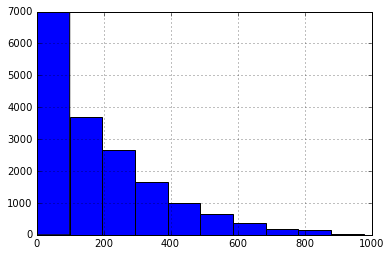

In [2]:
rentals['cnt'].hist()
plt.show()

This plot shows the distribution of the `cnt` column, which indicates the number of bikes rented in a given instant. The distribution is postively skewed, showing that it's more likely that a lower quantity bikes are out for a given hour. 

In [3]:
cors = rentals.corr()
print(cors['cnt'])

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


It appears that the `weathersituation` and `humidity` show a significant negative correlation with the number of bike rentals. It's understandable that temperature is positively correlated. I'm interested to see that rentals tended to increase year over year, which indicates that it takes some time for the rental system to build a user base. 

Lastly, the registered and casual columns will have to be removed from analysis, since they directly compose the count total

In [4]:
# Grouping the times of day together to create a morning, afternoon, night
# , and early morning grouping feature
def assign_label(hr):
    if hr <=6: return 4
    elif hr <= 12: return 1
    elif hr <= 18: return 2
    elif hr <= 24: return 3
    
rentals['time_label'] = rentals['hr'].apply(assign_label)

# Error Metric Selection
Using the data in this set, we are going to look at time of day, weather conditions, and seasonality to predict how many bikes will be rented in a given instant. Root Mean Squared Error (RMSE) is a great choice, because it emphasizes the accomodation of outliers by penalizing them more than an absolute error metric. 

In [5]:
split_row = round(rentals.shape[0]*0.8)
train = rentals[:split_row]
test = rentals[split_row:]

In [6]:
fit_cols = rentals.columns.tolist()
fit_cols.remove('casual')
fit_cols.remove('registered')
fit_cols.remove('cnt')
fit_cols.remove('dteday')

# Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
rentreg = LinearRegression()
rentreg.fit(train[fit_cols],train['cnt'])
linpreds = rentreg.predict(test[fit_cols])

In [12]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(test['cnt'],linpreds) ** 0.5)

164.159579028


### Linear Regression Conclusions
The RMSE calculated above shows that the predictions are usually about 161 bikes off the actual count. This is not a great value. In order to improve this prediction, more feature columns could be added. Instead, we'll see what decision trees and random forests have to offer.

# Decision Trees

In [13]:
from sklearn.tree import DecisionTreeRegressor
rentree = DecisionTreeRegressor(max_depth=11, min_samples_split=20, min_samples_leaf=16, max_features=None, random_state=3, max_leaf_nodes=None)
rentree.fit(train[fit_cols],train['cnt'])
treepreds = rentree.predict(test[fit_cols])
print(mean_squared_error(test['cnt'],treepreds) ** 0.5)

96.2019298202


The initial RMSE (without tinkering with the levers) was in the low 100s. Setting a value of 20 for the min_samples per split and a max depth of a 11 branches got us down to 96.2 RMSE. There is obviously still plenty of imprivement to be had.

# Random Forests

In [14]:
from sklearn.ensemble import RandomForestRegressor
rentforest = RandomForestRegressor(n_estimators=30, criterion='mse', max_depth=30, min_samples_split=20, min_samples_leaf=5, max_features='auto', max_leaf_nodes=None, random_state=1)
rentforest.fit(train[fit_cols],train['cnt'])
forpreds = rentforest.predict(test[fit_cols])
print(mean_squared_error(test['cnt'],forpreds) ** 0.5)

79.7877095988


Using the parameters listed above I was able to reduce the RMSE down to just under 80, but I think adding more features might be a more effective method of minimizing the error further. Adding extra forests will yield diminishing returns once the time needed to compute all of them becomes onerous.

# Adding a Feature
Let's try to give the addtional weather data more intelligence by creating an index that combines temperature, wind speed and humidity. Creating this index will create a better depiction of the numerical weather data with the qualitative forecast in `weathersit`. We'll calculate the difference between 1 and windspeed and humidity because the index should be indicate increasingly weather as it approaches the maximum value of 1. While windspeed is slightly  positively correlated with rental quantities, higher wind speeds create less favorable biking conditions. Humidity is negatively correlate with rental quanitites, so it is quantitatively apparent that high humidity negatively affects rental rates.

In [24]:
#print(rentals.describe())
rentals['weather_index'] = rentals['temp'] / 3 + (1 - rentals['windspeed']) / 3 + (1-rentals['hum']) / 3
fit_cols2 = rentals.columns.tolist()
fit_cols2.remove('casual')
fit_cols2.remove('registered')
fit_cols2.remove('cnt')
fit_cols2.remove('dteday')

train = rentals[:split_row]
test = rentals[split_row:]

rentforest2 = RandomForestRegressor(n_estimators=30, criterion='mse', max_depth=30, min_samples_split=20, min_samples_leaf=5, max_features='auto', max_leaf_nodes=None, random_state=1)
rentforest2.fit(train[fit_cols2],train['cnt'])
forpreds2 = rentforest2.predict(test[fit_cols2])
print('Root Mean Squared Error: ',mean_squared_error(test['cnt'],forpreds2) ** 0.5)

Root Mean Squared Error:  77.3417764203


Adding the `weather_index` feature substantially improved the model. The RMSE decreased from 79.79 to 77.34. Adding more features that contain relevant organization of the data will likely further improve the model. Additionally, removing less relevant features using a selection algorithm may also improve the data. 